In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Differences in lineage characteristics between cross-border and domestic introductions.
We measure epidemiologically relevent characterisitics of transmission lineages in San Diego and assess whether there are significant differences between lineages which cross the border and those that done.

For each tree in the posterior, we identify San Diego lineages as nodes which location state is assigned `San Diego` and whose parent node's location state is assigned something else. For each lineage, we calculate the parent's location state, the time of the first San Diego node, the collection date of the earliest direct descendent, the collection date of the latest direct descendent and the total number of direct descendents.

All of these characteristics are collected into a tidy DataFrame.

NOTE: this cell takes a considerable amount of time to run, so if necessary, we'll save it to file for later analysis.

In [6]:
def get_children( node, field ):
    return_list = []
    location = node.annotations.get_value( field )
    for j in node.child_node_iter( lambda x: x.annotations.get_value( field ) == location ):
        if j.is_leaf():
            return_list.append( j )
        else:
            return_list.extend( get_children( j, field ) )
    return return_list

def get_ancestral_state( node, threshold, field ):
    return next( node.ancestor_iter() ).annotations.get_value( field )

def get_introductions( tree, field, interest, threshold=0.5, root_height=0 ):
    return_list = list()
    def _identity_func( node ):
        if node.parent_node is None:
            return False
        return (node.annotations.get_value( field ) == interest) & (get_ancestral_state( node, threshold, field ) != interest)

    for i in tree.preorder_node_iter( filter_fn=_identity_func ):
        node_dict = i.annotations.values_as_dict()
        node_dict[f"par.{field}"] = get_ancestral_state( i, threshold, field )

        children = get_children( i, field )
        children_dates = [root_height + float( child.root_distance ) for child in children]
        node_dict["children"] = len( children )
        node_dict["children.names"] = [child.taxon.label for child in children]
        if len( children ) > 0:
            node_dict["earliest_date"] = min( children_dates )
            node_dict["latest_date"] = max( children_dates )
        node_dict["children.dates"] = children_dates
        node_dict["height"] = root_height + i.root_distance
        return_list.append( node_dict )
    return pd.DataFrame( return_list )

file_loc = "../data/2021-08-30_fixed_eponential_discrete.trees"
output_loc = ""
file_fmt = "nexus"
burnin = 100

yielder = Tree.yield_from_files( files=[file_loc], schema=file_fmt, preserve_underscores=True )

recent_date = 0

output_df = list()

for tree_idx, t in enumerate( yielder ):
    temp = t 
    if tree_idx == 0:
        recent_date = _toYearFraction( max( [i.label.split( "|" )[-1] for i in t.taxon_namespace] )[-20:] )
    if tree_idx < burnin:
        continue
    start_time = time.time()
    print( f"Processing {tree_idx - burnin} tree...", end="" )
    
    root_height = recent_date - t.max_distance_from_root()
    t.calc_node_root_distances()
    
    for loc in ["San Diego"]:
        temp_df = get_introductions( t, "Location", loc, root_height=root_height )
        temp_df["tree"] = tree_idx
        output_df.append( temp_df )
    
    execution_time = time.time() - start_time
    print( f" Done in {execution_time:.1f} seconds" )

output_df = pd.concat( output_df )
output_df.head()

Processing 0 tree... Done in 0.1 seconds
Processing 1 tree... Done in 0.1 seconds
Processing 2 tree... Done in 0.1 seconds
Processing 3 tree... Done in 0.1 seconds
Processing 4 tree... Done in 0.1 seconds
Processing 5 tree... Done in 0.1 seconds
Processing 6 tree... Done in 0.1 seconds
Processing 7 tree... Done in 0.1 seconds
Processing 8 tree... Done in 0.1 seconds
Processing 9 tree... Done in 0.1 seconds
Processing 10 tree... Done in 0.1 seconds
Processing 11 tree... Done in 0.1 seconds
Processing 12 tree... Done in 0.1 seconds
Processing 13 tree... Done in 0.1 seconds
Processing 14 tree... Done in 0.1 seconds
Processing 15 tree... Done in 0.1 seconds
Processing 16 tree... Done in 0.1 seconds
Processing 17 tree... Done in 0.1 seconds
Processing 18 tree... Done in 0.1 seconds
Processing 19 tree... Done in 0.1 seconds
Processing 20 tree... Done in 0.1 seconds
Processing 21 tree... Done in 0.1 seconds
Processing 22 tree... Done in 0.1 seconds
Processing 23 tree... Done in 0.1 seconds
Pr

Processing 194 tree... Done in 0.1 seconds
Processing 195 tree... Done in 0.1 seconds
Processing 196 tree... Done in 0.1 seconds
Processing 197 tree... Done in 0.1 seconds
Processing 198 tree... Done in 0.1 seconds
Processing 199 tree... Done in 0.1 seconds
Processing 200 tree... Done in 0.1 seconds
Processing 201 tree... Done in 0.1 seconds
Processing 202 tree... Done in 0.3 seconds
Processing 203 tree... Done in 0.1 seconds
Processing 204 tree... Done in 0.1 seconds
Processing 205 tree... Done in 0.1 seconds
Processing 206 tree... Done in 0.1 seconds
Processing 207 tree... Done in 0.1 seconds
Processing 208 tree... Done in 0.1 seconds
Processing 209 tree... Done in 0.1 seconds
Processing 210 tree... Done in 0.1 seconds
Processing 211 tree... Done in 0.1 seconds
Processing 212 tree... Done in 0.1 seconds
Processing 213 tree... Done in 0.1 seconds
Processing 214 tree... Done in 0.1 seconds
Processing 215 tree... Done in 0.1 seconds
Processing 216 tree... Done in 0.1 seconds
Processing 

Processing 385 tree... Done in 0.1 seconds
Processing 386 tree... Done in 0.1 seconds
Processing 387 tree... Done in 0.1 seconds
Processing 388 tree... Done in 0.1 seconds
Processing 389 tree... Done in 0.1 seconds
Processing 390 tree... Done in 0.1 seconds
Processing 391 tree... Done in 0.1 seconds
Processing 392 tree... Done in 0.1 seconds
Processing 393 tree... Done in 0.1 seconds
Processing 394 tree... Done in 0.1 seconds
Processing 395 tree... Done in 0.1 seconds
Processing 396 tree... Done in 0.1 seconds
Processing 397 tree... Done in 0.1 seconds
Processing 398 tree... Done in 0.1 seconds
Processing 399 tree... Done in 0.1 seconds
Processing 400 tree... Done in 0.1 seconds
Processing 401 tree... Done in 0.1 seconds
Processing 402 tree... Done in 0.1 seconds
Processing 403 tree... Done in 0.1 seconds
Processing 404 tree... Done in 0.1 seconds
Processing 405 tree... Done in 0.1 seconds
Processing 406 tree... Done in 0.1 seconds
Processing 407 tree... Done in 0.1 seconds
Processing 

Processing 576 tree... Done in 0.1 seconds
Processing 577 tree... Done in 0.1 seconds
Processing 578 tree... Done in 0.1 seconds
Processing 579 tree... Done in 0.1 seconds
Processing 580 tree... Done in 0.1 seconds
Processing 581 tree... Done in 0.1 seconds
Processing 582 tree... Done in 0.1 seconds
Processing 583 tree... Done in 0.1 seconds
Processing 584 tree... Done in 0.1 seconds
Processing 585 tree... Done in 0.1 seconds
Processing 586 tree... Done in 0.1 seconds
Processing 587 tree... Done in 0.1 seconds
Processing 588 tree... Done in 0.1 seconds
Processing 589 tree... Done in 0.1 seconds
Processing 590 tree... Done in 0.1 seconds
Processing 591 tree... Done in 0.1 seconds
Processing 592 tree... Done in 0.1 seconds
Processing 593 tree... Done in 0.1 seconds
Processing 594 tree... Done in 0.1 seconds
Processing 595 tree... Done in 0.1 seconds
Processing 596 tree... Done in 0.1 seconds
Processing 597 tree... Done in 0.1 seconds
Processing 598 tree... Done in 0.1 seconds
Processing 

Processing 767 tree... Done in 0.1 seconds
Processing 768 tree... Done in 0.1 seconds
Processing 769 tree... Done in 0.1 seconds
Processing 770 tree... Done in 0.1 seconds
Processing 771 tree... Done in 0.1 seconds
Processing 772 tree... Done in 0.1 seconds
Processing 773 tree... Done in 0.1 seconds
Processing 774 tree... Done in 0.1 seconds
Processing 775 tree... Done in 0.1 seconds
Processing 776 tree... Done in 0.4 seconds
Processing 777 tree... Done in 0.1 seconds
Processing 778 tree... Done in 0.1 seconds
Processing 779 tree... Done in 0.1 seconds
Processing 780 tree... Done in 0.1 seconds
Processing 781 tree... Done in 0.1 seconds
Processing 782 tree... Done in 0.1 seconds
Processing 783 tree... Done in 0.1 seconds
Processing 784 tree... Done in 0.1 seconds
Processing 785 tree... Done in 0.1 seconds
Processing 786 tree... Done in 0.1 seconds
Processing 787 tree... Done in 0.1 seconds
Processing 788 tree... Done in 0.1 seconds
Processing 789 tree... Done in 0.1 seconds
Processing 

,Location,Location.rate,par.Location,children,children.names,children.dates,height,earliest_date,latest_date,tree
0,San Diego,0.9517669509105722,Rest of World,0,[],[],2020.778575,NaN,NaN,100
1,San Diego,0.9517669509105722,Baja California,0,[],[],2020.975410,NaN,NaN,100
2,San Diego,0.9517669509105722,Baja California,0,[],[],2020.994536,NaN,NaN,100
3,San Diego,0.9517669509105722,Baja California,0,[],[],2020.898907,NaN,NaN,100
4,San Diego,0.9517669509105722,Los Angeles,0,[],[],2020.532673,NaN,NaN,100


We convert node heights to time (in units of decimal year) by subtracting from the most recent sampled date in the tree.

We also calculate the detection delay of each lineage as the time from the introduction date to the earliest direct descendent, and the lineage length as the time from the introduction date to the date of the last direct descendent.

In [8]:
output_df["delay"] = output_df["earliest_date"] - output_df["height"]
output_df["lineage_length"] = output_df["latest_date"] - output_df["height"]
output_df.to_csv( "2021-08-30_fixed_eponential_discrete.lineages.csv" )
output_df.head()

,Location,Location.rate,par.Location,children,children.names,children.dates,height,earliest_date,latest_date,tree,delay,lineage_length
0,San Diego,0.9517669509105722,Rest of World,0,[],[],2020.778575,NaN,NaN,100,NaN,NaN
1,San Diego,0.9517669509105722,Baja California,0,[],[],2020.975410,NaN,NaN,100,NaN,NaN
2,San Diego,0.9517669509105722,Baja California,0,[],[],2020.994536,NaN,NaN,100,NaN,NaN
3,San Diego,0.9517669509105722,Baja California,0,[],[],2020.898907,NaN,NaN,100,NaN,NaN
4,San Diego,0.9517669509105722,Los Angeles,0,[],[],2020.532673,NaN,NaN,100,NaN,NaN


Again, the above analysis takes up to 15 minutes, so we cache the results to load here.

In [2]:
tr = pd.read_csv( "2021-08-30_fixed_eponential_discrete.lineages.csv" )
tr = tr.drop( columns=["Unnamed: 0"] )
tr["height"] = tr["height"].apply( dec_to_date ).dt.normalize()
#tr["week"] = tr["height"].apply( lambda x: Week.fromdate(x).startdate() )
tr["month"] = tr["height"].astype( 'datetime64[M]' )
tr[["delay","lineage_length"]] *= 365
#tr.loc[tr["children"]==0,"children"] = 1
tr = tr.loc[tr["children"]>0]
tr.head()

,Location,Location.rate,par.Location,children,children.names,children.dates,height,earliest_date,latest_date,tree,delay,lineage_length,month
6,San Diego,0.951767,Los Angeles,1,['USA|California-SanDiegoCounty|EPI_ISL_223129...,[2020.950819672131],2020-10-11,2020.950820,2020.950820,100,63.183154,63.183154,2020-10-01
9,San Diego,0.951767,Los Angeles,2,['USA|California-SanDiegoCounty|EPI_ISL_179144...,"[2021.2382420091321, 2021.2382420091321]",2021-03-19,2021.238242,2021.238242,100,8.988644,8.988644,2021-03-01
19,San Diego,0.951767,Los Angeles,2,['USA|California-SanDiegoCounty|EPI_ISL_635710...,"[2020.5599954462657, 2020.5791211293258]",2020-07-20,2020.579121,2020.559995,100,10.459941,3.479067,2020-07-01
21,San Diego,0.951767,Los Angeles,1,['USA|California-SanDiegoCounty|EPI_ISL_635411...,[2020.5162795992712],2020-06-28,2020.516280,2020.516280,100,9.697795,9.697795,2020-06-01
22,San Diego,0.951767,Mexico,4,['USA|California-SanDiegoCounty|EPI_ISL_755177...,"[2020.950819672131, 2021.1397260273973, 2021.0...",2020-08-22,2021.139726,2020.770378,100,182.630289,47.818245,2020-08-01


In [3]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

sig_test = {
    "month" : [],
    "trait" : [],
    "pvalue" : []
}
for month, group in tr.groupby( ["month"] ):
    for trait in ["children", "delay", "lineage_length"]:
        try:
            result = mannwhitneyu( group.loc[group["par.Location"]=="Baja California",trait].dropna(), group.loc[group["par.Location"]=="Los Angeles",trait].dropna())
        except ValueError as err:
            print( err )
            continue
        sig_test["month"].append( month )
        sig_test["trait"].append( trait )
        sig_test["pvalue"].append( result.pvalue )
sig_test = pd.DataFrame( sig_test )
sig_test = sig_test.dropna()
results = multipletests( sig_test["pvalue"], alpha=0.05, method="fdr_bh" )
sig_test["corrected"] = results[1]
sig_test["reject_h0"] = results[0]
sig_test = sig_test.sort_values( ["trait","month"] )
sig_test.to_csv( "test.csv", index=False  )

`x` and `y` must be of nonzero size.
`x` and `y` must be of nonzero size.
`x` and `y` must be of nonzero size.
`x` and `y` must be of nonzero size.
`x` and `y` must be of nonzero size.
`x` and `y` must be of nonzero size.
`x` and `y` must be of nonzero size.
`x` and `y` must be of nonzero size.
`x` and `y` must be of nonzero size.


In [4]:
get_low = lambda x: x.quantile( 0.025 )
get_high = lambda x: x.quantile( 0.975 )

num_t = tr.groupby( ["par.Location", "month", "tree"] )["height"].agg( "count" )
num_t = num_t.reset_index()
num_t = num_t.groupby( ["par.Location", "month"] ).agg( transitions=("height", "median" ),
                                                       transitions_low=("height", get_low ),
                                                       transitions_high=("height", get_high ) )


plot_df = tr.groupby( ["par.Location", "month"] ).agg( children=("children", "median"),
                                                           children_low=("children", get_low ),
                                                           children_high=("children", get_high ),
                                                           delay=("delay", "median"),
                                                           delay_low=("delay", get_low),
                                                           delay_high=("delay", get_high),
                                                           lineage_length=("lineage_length", "median"),
                                                           lineage_length_low=("lineage_length", get_low),
                                                           lineage_length_high=("lineage_length", get_high) )

plot_df = plot_df.merge( num_t, left_index=True, right_index=True, how="outer")
plot_df = plot_df.reset_index()
plot_df.head()

,par.Location,month,children,children_low,children_high,delay,delay_low,delay_high,lineage_length,lineage_length_low,lineage_length_high,transitions,transitions_low,transitions_high
0,Baja California,2020-02-01,2.0,1.0,4.00,80.180188,51.025233,206.249694,53.576626,45.184444,80.951994,1.0,1,1.0
1,Baja California,2020-03-01,2.0,1.0,5.75,60.812017,3.744295,292.043592,40.927063,2.470634,104.628538,1.0,1,2.0
2,Baja California,2020-04-01,2.0,1.0,8.00,78.505980,5.255877,286.525795,28.712912,0.996076,119.677005,2.0,1,4.0
3,Baja California,2020-05-01,2.0,1.0,14.00,68.559748,3.791882,277.943388,40.630867,2.681104,224.328769,4.0,1,7.0
4,Baja California,2020-06-01,2.0,1.0,14.00,40.715930,13.433266,263.518080,21.081099,1.442133,199.275621,6.0,3,9.0


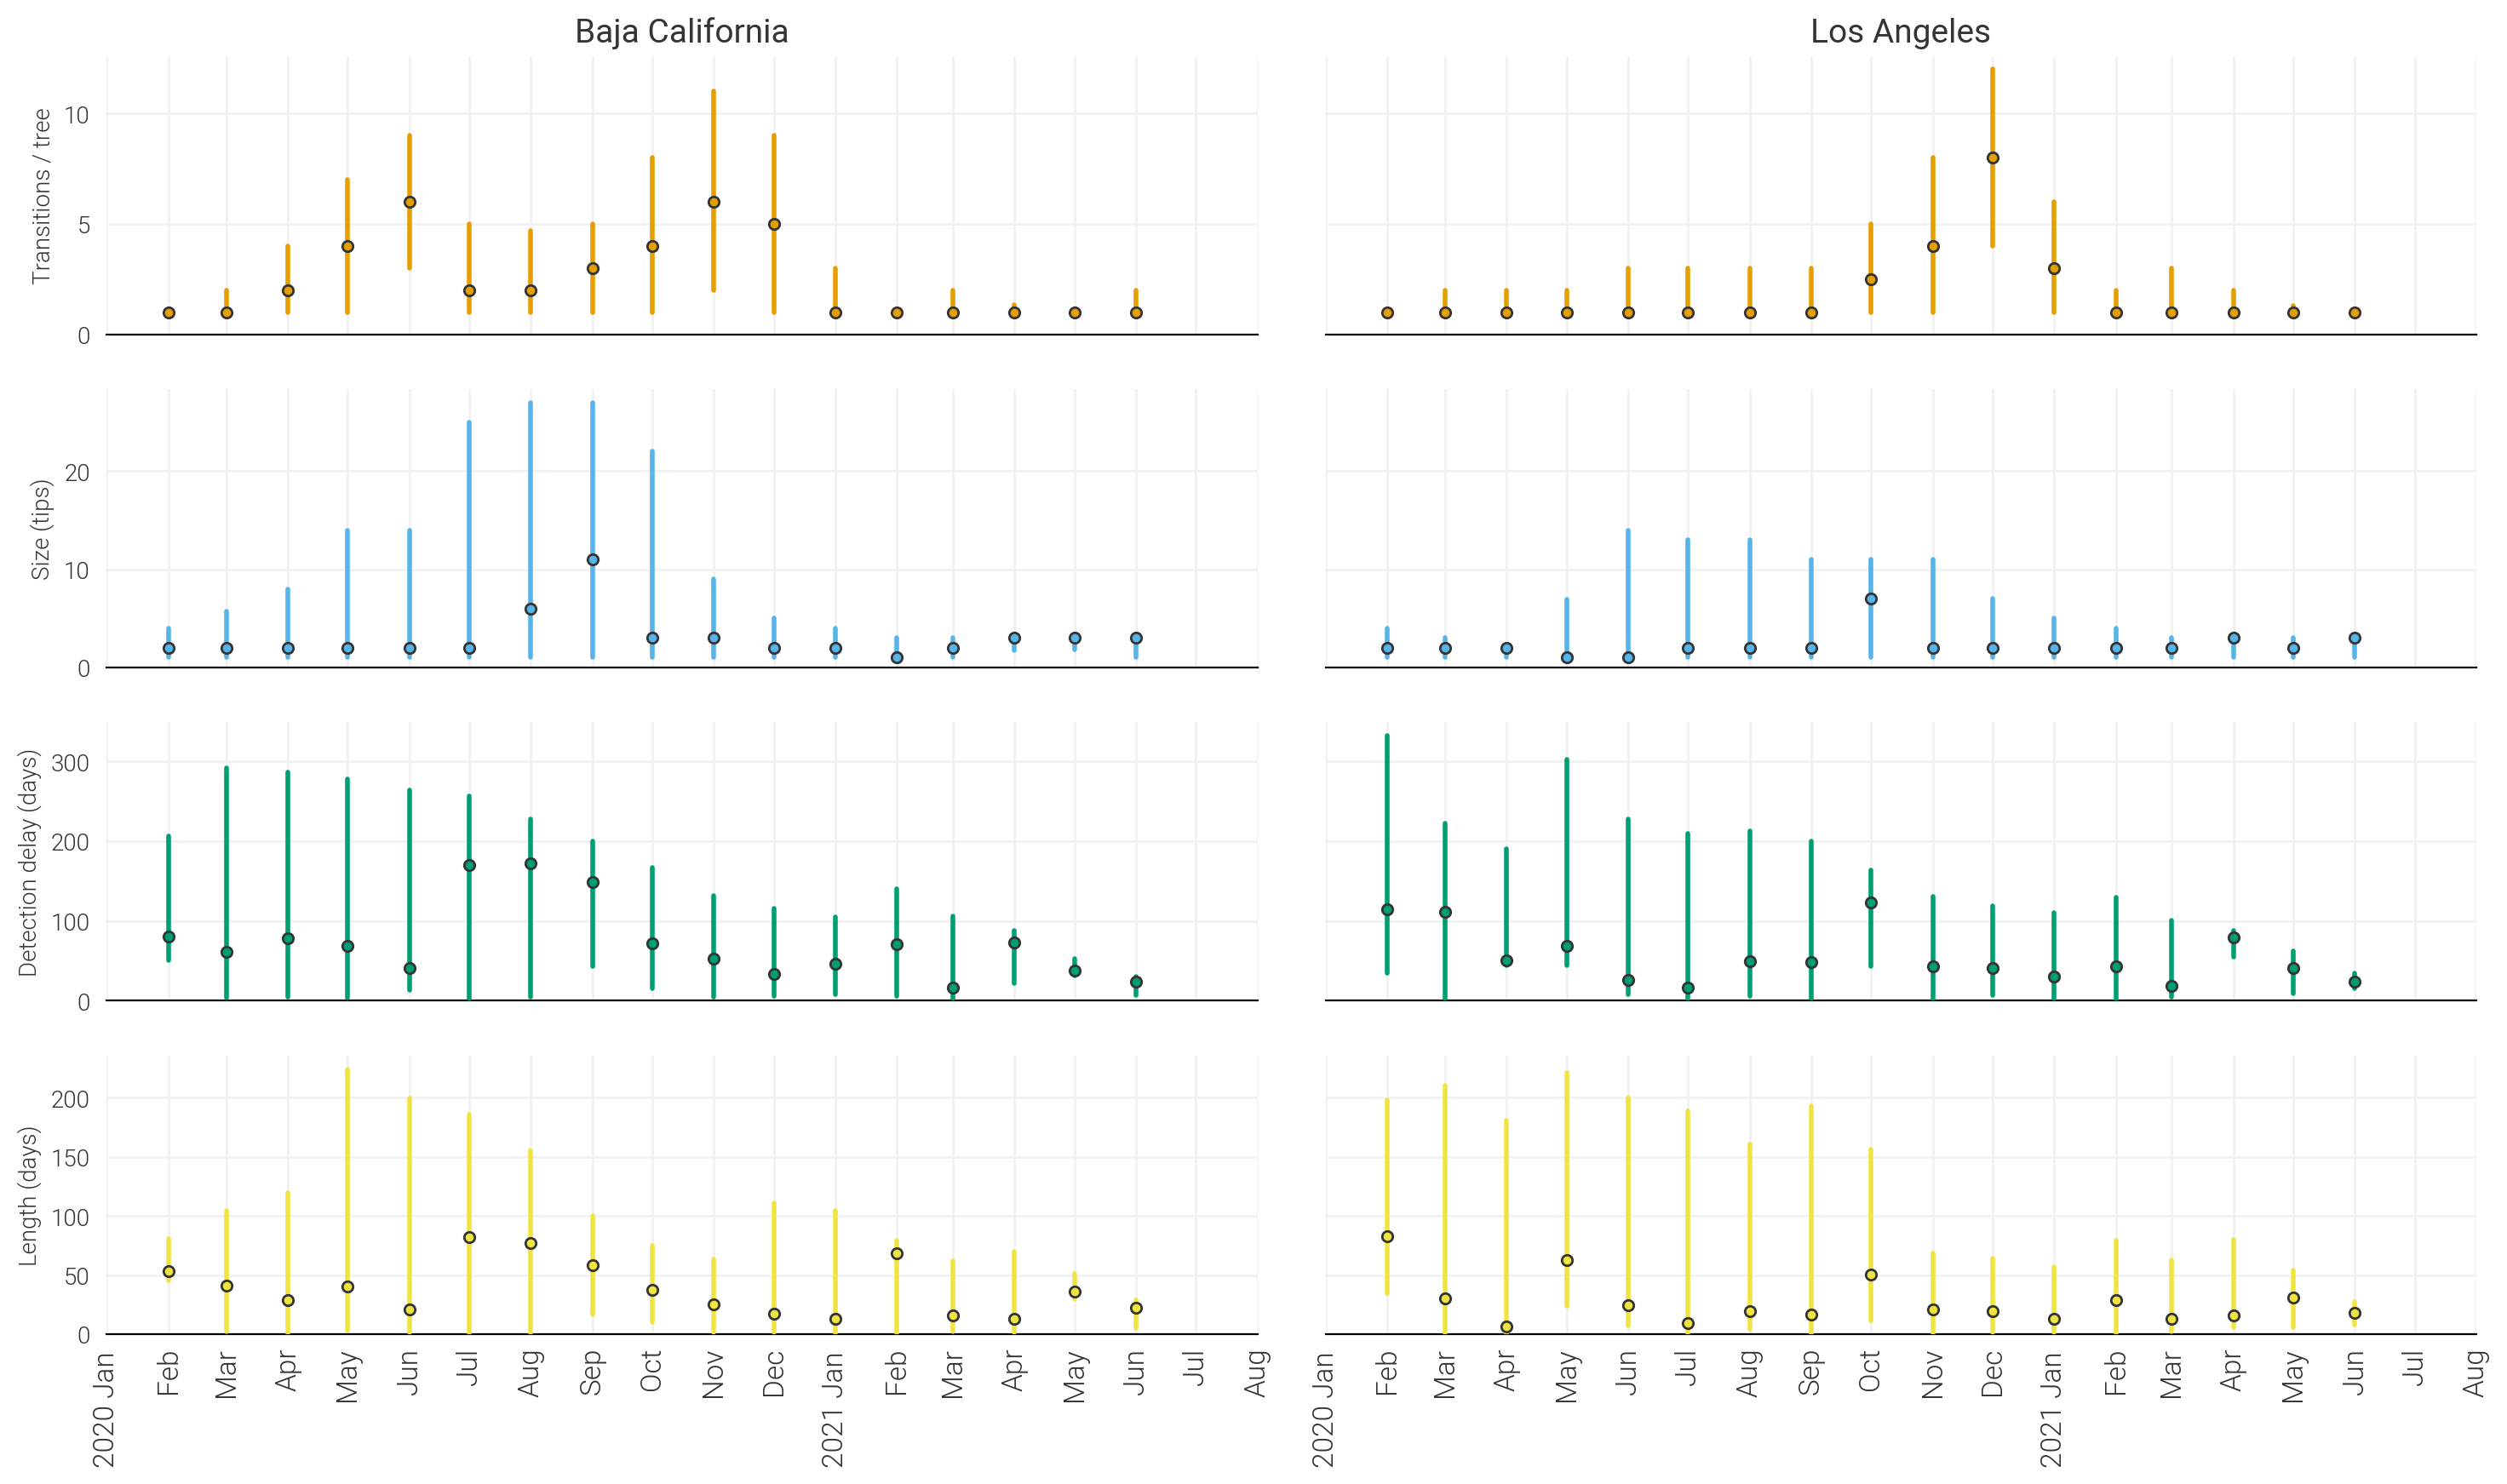

In [5]:
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]
col_names = ["Transitions / tree", "Size (tips)", "Detection delay (days)", "Length (days)"]

col1 = plot_df.loc[plot_df["par.Location"]=="Baja California"]
col2 = plot_df.loc[plot_df["par.Location"]=="Los Angeles"]

fig, ax = plt.subplots( dpi=200, figsize=(15,9), nrows=4, ncols=2, sharex=True )
for i, col in enumerate( ["transitions", "children", "delay", "lineage_length"] ):
    ymax = max( col1[f"{col}_high"].max(), col2[f"{col}_high"].max() )
    for j, location in enumerate( [col1, col2] ):
        ln = ax[i,j].vlines( "month", f"{col}_low", f"{col}_high", data=location, color=colors[i], zorder=4, linewidths=2 )
        ln.set_capstyle( "round" )
        ax[i,j].scatter( "month", col, data=location, color=colors[i], zorder=5, edgecolor=COLOR, linewidths=1, s=20 )
        date_range = (pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01") )
        basic_formatting( ax[i,j], which="both", xlims=date_range, ylims=(0, ymax*1.05), ylabel=col_names[i], ysize=10 )
        timeseries_formatting( ax[i,j] )
        ax[i,j].label_outer()

ax[0,0].set_title( "Baja California", fontsize=14 )
ax[0,1].set_title( "Los Angeles", fontsize=14 )
plt.tight_layout()
#plt.savefig( "../analyses/plots/figureX_cross-border-lineage-characteristics.pdf" )
plt.show()

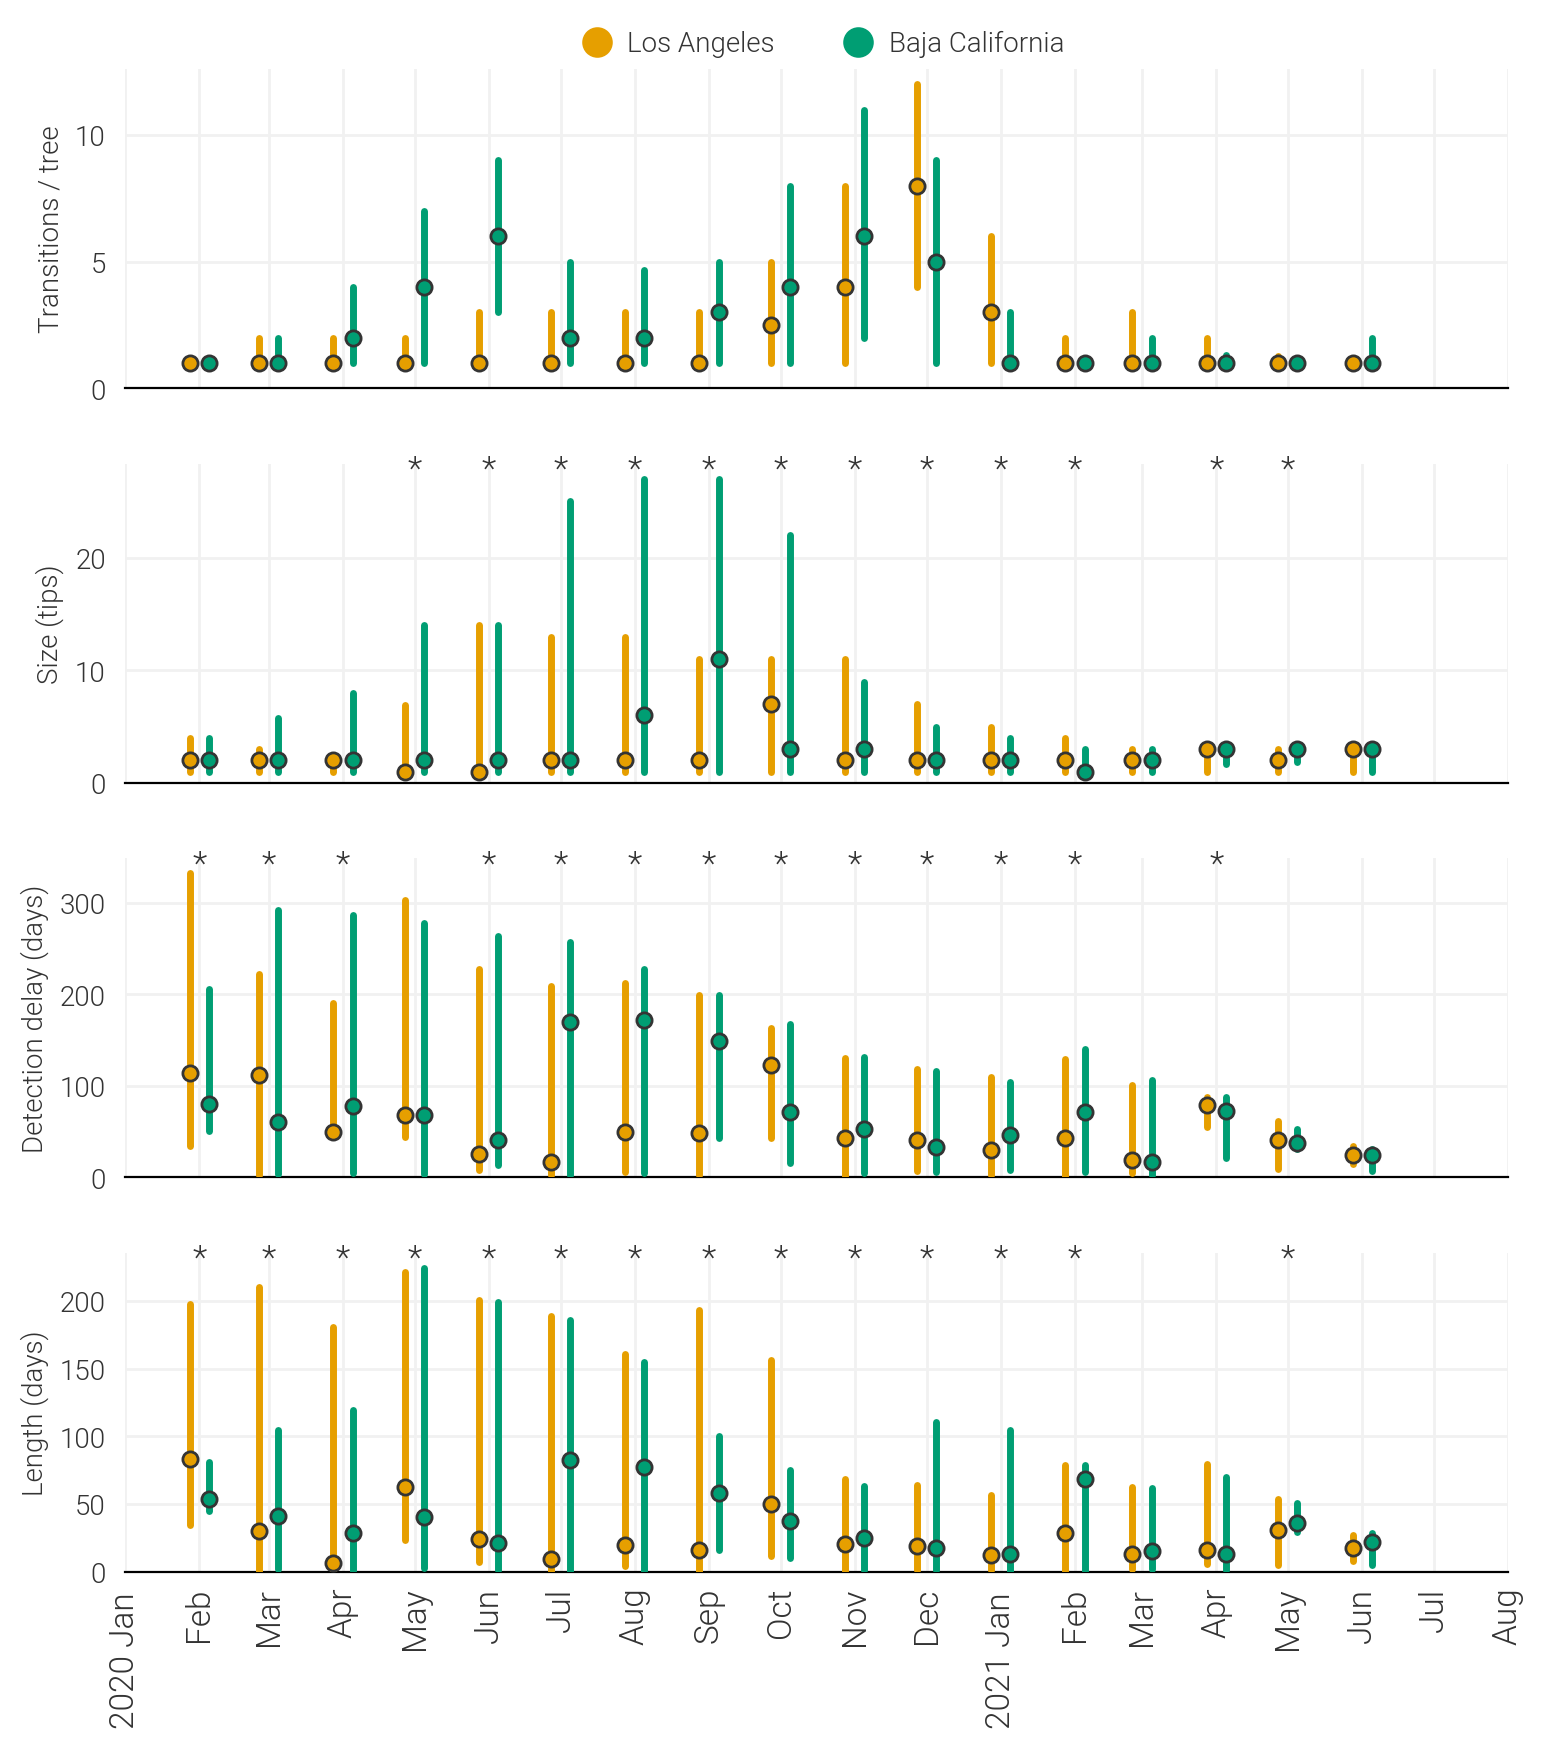

In [6]:
delta = pd.to_timedelta(4, "d" )

colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]
col_names = ["Transitions / tree", "Size (tips)", "Detection delay (days)", "Length (days)"]

col1 = plot_df.loc[plot_df["par.Location"]=="Baja California"]
col2 = plot_df.loc[plot_df["par.Location"]=="Los Angeles"]

fig, ax = plt.subplots( dpi=200, figsize=(8,9), nrows=4, sharex=True )
for i, col in enumerate( ["transitions", "children", "delay", "lineage_length"] ):
    ymax = max( col1[f"{col}_high"].max(), col2[f"{col}_high"].max() )
    ln = ax[i].vlines( col1["month"] + delta, col1[f"{col}_low"], col1[f"{col}_high"], color="#009E73", zorder=4, linewidths=2.5 )
    ln.set_capstyle( "round" )
    ln = ax[i].vlines( col2["month"] - delta, col2[f"{col}_low"], col2[f"{col}_high"], color="#E69F00", zorder=4, linewidths=2.5 )
    ln.set_capstyle( "round" )
    ax[i].scatter( col1["month"] + delta, col, data=col1, color="#009E73", zorder=5, edgecolor=COLOR, linewidths=1, s=30 )
    ax[i].scatter( col2["month"] - delta, col, data=col2, color="#E69F00", zorder=5, edgecolor=COLOR, linewidths=1, s=30 )
    date_range = (pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01") )

    if col != "transitions":
        for _, pvalue in sig_test.loc[(sig_test["trait"]==col)&sig_test["reject_h0"]].iterrows():

            ax[i].text( pvalue["month"], ymax, "*", fontsize=12, ha="center" )

    basic_formatting( ax[i], which="both", xlims=date_range, ylims=(0, ymax*1.05), ylabel=col_names[i], ysize=10 )
    timeseries_formatting( ax[i] )
    ax[i].label_outer()

legend = [Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="Los Angeles", markersize=10 ),
          Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Baja California", markersize=10 )]
ax[0].legend( loc="upper center", handletextpad=0.1, handles=legend, frameon=False, fontsize=10, ncol=2,
          bbox_to_anchor=(0,0,1,1.2) )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_cross-border-lineage-characteristics.pdf" )
plt.show()